In [720]:
import warnings
warnings.filterwarnings("ignore")
import os
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk import PorterStemmer,SnowballStemmer
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm_notebook as tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from PIL import Image
import math
import datetime

In [721]:
tr_var=pd.read_csv('training_variants')
tr_text=pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
tr_var.head()

ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

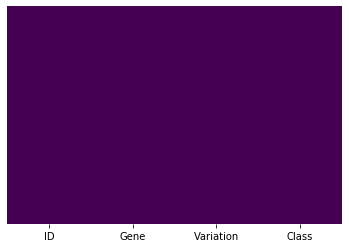

In [540]:
#checking for null values:
plt.figure(figsize=(6,4))
sns.heatmap(data=tr_var.isnull(),cbar=False,yticklabels=False,cmap='viridis')

### EDA 
#### UNIVARIATE ANALYSIS
##### GENE

In [722]:
print("Train data has shape ",tr_var.shape)

Train data has shape  (3321, 4)


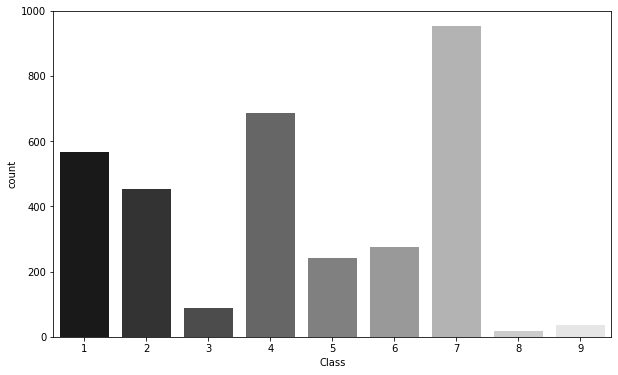

In [723]:
plt.figure(figsize=(10,6))
sns.countplot(x=tr_var['Class'],palette='gist_gray')
plt.show()

#### records corresponding to classes 3,8,9 are very few ,stratified sampling and balancing the data should be considered for better results.

In [724]:
tr_var['Gene'].describe()

count      3321
unique      264
top       BRCA1
freq        264
Name: Gene, dtype: object

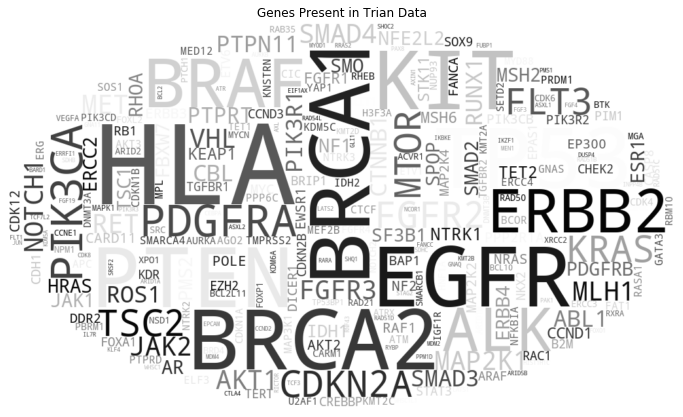

In [725]:
m1=np.array(Image.open('MSK2.png'))
G=""
for genes in tr_var['Gene'].value_counts().index:
    G+=genes+" "
    
wcg=WordCloud(background_color='white',max_words=len(G.split()),mask=m1,colormap='gist_gray').generate(G.strip())
plt.figure(figsize=(12,9))
plt.imshow(wcg,interpolation='bilinear')
plt.axis('off')
plt.title('Genes Present in Trian Data')
plt.show()

In [726]:
tr_var['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

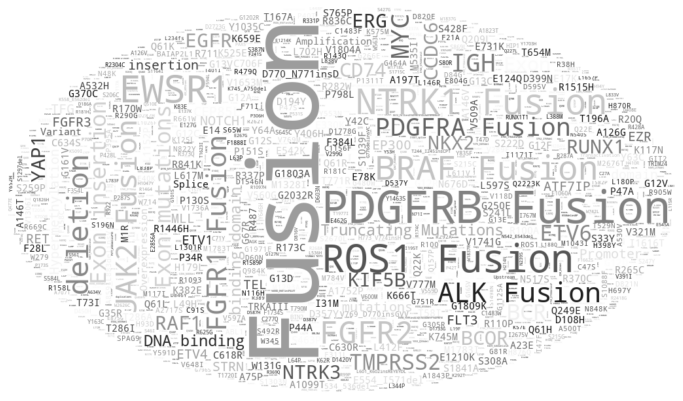

In [727]:
V=""
for vrtion in tr_var['Variation'].value_counts().index:
    V+=vrtion+" "
    
wcv=WordCloud(width=600,height=400,background_color='white',\
              max_words=len(V.split()),mask=m1,colormap='gist_gray').generate(V.strip())
plt.figure(figsize=(12,9))
plt.imshow(wcv,interpolation='bilinear')
plt.axis('off')
plt.show()

In [728]:
gene_tr=tr_var.groupby('Gene')['ID'].count().sort_values(ascending=False).reset_index()

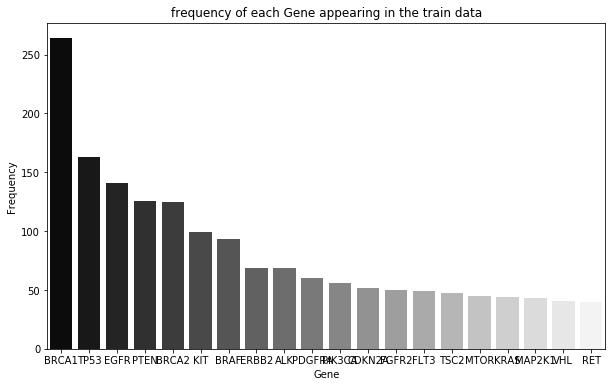

In [729]:
plt.figure(figsize=(10,6))
sns.barplot(x='Gene',y='ID',data=gene_tr[:20],palette='gist_gray')
plt.title("frequency of each Gene appearing in the train data")
plt.ylabel('Frequency')
plt.show()

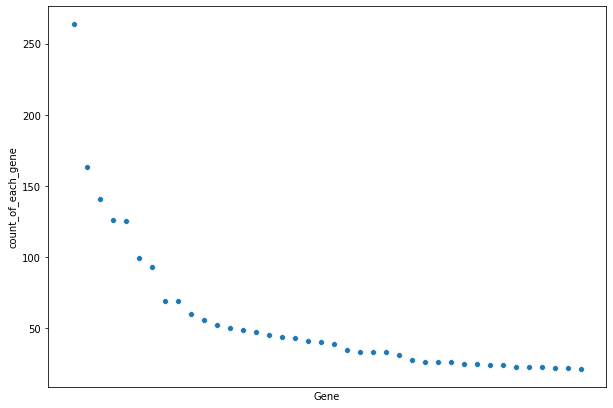

In [730]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='Gene',y='ID',data=gene_tr[:40])
plt.ylabel("count_of_each_gene")
plt.xticks([],[])
plt.show()

### VARIATION

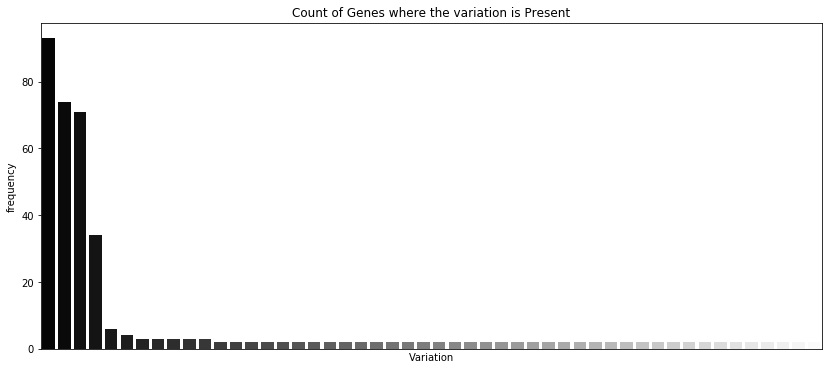


Top 4 variations are


['Truncating Mutations', 'Deletion', 'Amplification', 'Fusions']

In [731]:
var_tr=tr_var.groupby('Variation')['ID'].count().sort_values(ascending=False).reset_index()
plt.figure(figsize=(14,6))
sns.barplot(x='Variation',y='ID',data=var_tr[:50],palette='gist_gray')
plt.ylabel("frequency")
plt.xticks([],[])
plt.title("Count of Genes where the variation is Present")
plt.show()

print("\nTop 4 variations are")
list(var_tr['Variation'][:4].values)

##### some variations are occuring very frequently whereas others are occuring less than 5

### feature interaction

#### between gene and class
#### between variation and class

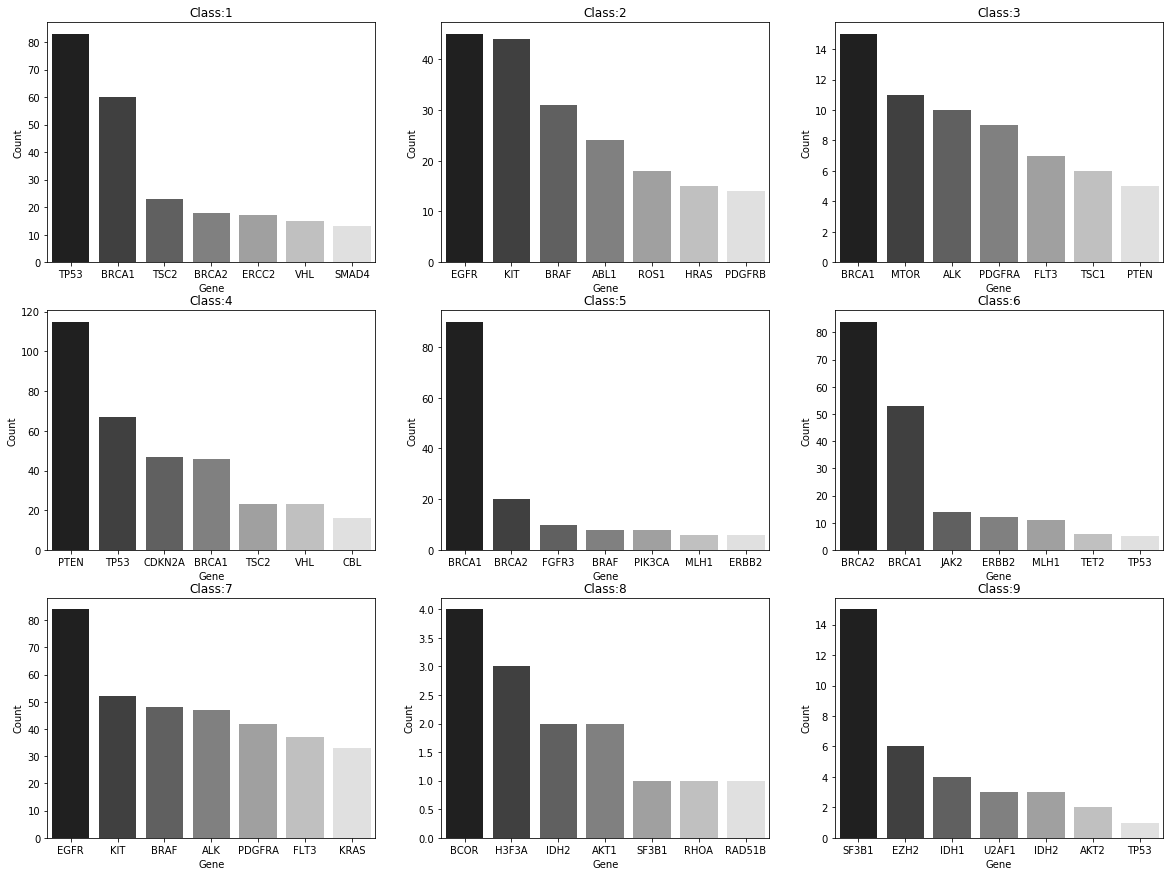

In [732]:
fig,ax=plt.subplots(3,3,figsize=(20,15))
plt.title("Top 7 most frequent genes in each class")
for i in range(3):
    for j in range(3):
        to_b_p=tr_var[tr_var['Class']==(i*3+j+1)].groupby('Gene')['ID'].count()\
                        .sort_values(ascending=False).reset_index()[:7]
        sns.barplot(x='Gene',y='ID',data=to_b_p,ax=ax[i][j],palette='gist_gray')
        ax[i][j].set_ylabel('Count')
        ax[i][j].set_title("Class:"+str(i*3+j+1))


In [733]:
for i in range(9):
    print("Number Of unique Genes in Class:",i+1)
    print(tr_var[tr_var['Class']==i+1]['Gene'].unique().shape[0])

Number Of unique Genes in Class: 1
142
Number Of unique Genes in Class: 2
96
Number Of unique Genes in Class: 3
26
Number Of unique Genes in Class: 4
92
Number Of unique Genes in Class: 5
48
Number Of unique Genes in Class: 6
56
Number Of unique Genes in Class: 7
108
Number Of unique Genes in Class: 8
12
Number Of unique Genes in Class: 9
10


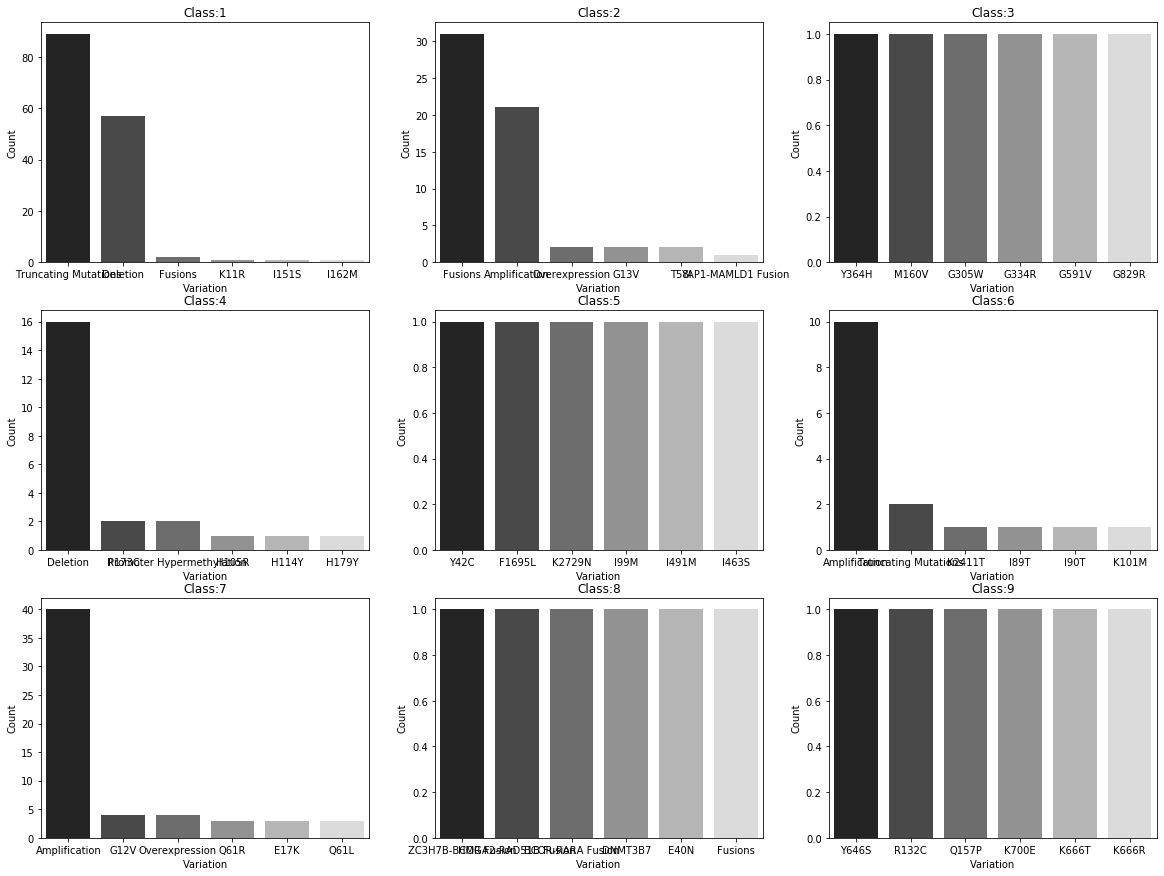

In [734]:
fig,ax=plt.subplots(3,3,figsize=(20,15))
for i in range(3):
    for j in range(3):
        to_b_p=tr_var[tr_var['Class']==(i*3+j+1)].groupby('Variation')['ID'].count()\
        .sort_values(ascending=False).reset_index()[:6]
        
        sns.barplot(x='Variation',y='ID',data=to_b_p,ax=ax[i][j],palette='gist_gray')
        ax[i][j].set_ylabel('Count')
        ax[i][j].set_title("Class:"+str(i*3+j+1))

In [735]:
#SOMETHING INTRESTING IS GOING ON WITH 3 5 8 9 classes

x_ax_3=tr_var[tr_var['Class']==3]['Variation'].value_counts().index
y_ax_3=tr_var[tr_var['Class']==3]['Variation'].value_counts().values

x_ax_5=tr_var[tr_var['Class']==5]['Variation'].value_counts().index
y_ax_5=tr_var[tr_var['Class']==5]['Variation'].value_counts().values

x_ax_8=tr_var[tr_var['Class']==8]['Variation'].value_counts().index
y_ax_8=tr_var[tr_var['Class']==8]['Variation'].value_counts().values

x_ax_9=tr_var[tr_var['Class']==9]['Variation'].value_counts().index
y_ax_9=tr_var[tr_var['Class']==9]['Variation'].value_counts().values

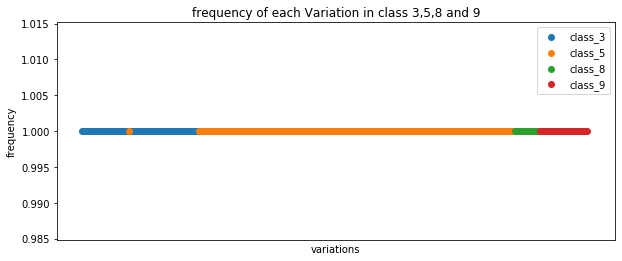

In [736]:
plt.figure(figsize=(10,4))
plt.scatter(x=x_ax_3,y=y_ax_3,label='class_3')
plt.scatter(x=x_ax_5,y=y_ax_5,label='class_5')
plt.scatter(x=x_ax_8,y=y_ax_8,label='class_8')
plt.scatter(x=x_ax_9,y=y_ax_9,label='class_9')
plt.ylabel("frequency")
plt.xlabel("variations")
plt.xticks([],[])
plt.legend()
plt.title("frequency of each Variation in class 3,5,8 and 9")
plt.show()

In [737]:
for i in range(9):
    print("Number Of unique variation in Class:",i+1)
    print(tr_var[tr_var['Class']==i+1]['Variation'].unique().shape[0])

Number Of unique variation in Class: 1
423
Number Of unique variation in Class: 2
399
Number Of unique variation in Class: 3
89
Number Of unique variation in Class: 4
669
Number Of unique variation in Class: 5
242
Number Of unique variation in Class: 6
265
Number Of unique variation in Class: 7
889
Number Of unique variation in Class: 8
19
Number Of unique variation in Class: 9
37


### Feature interaction between Gene and variation

In [738]:
g_V=tr_var['Gene']+tr_var['Variation']
g_V.describe()

count          3321
unique         3321
top       ALKL1198P
freq              1
dtype: object

#### Gene+Variation is a unique pair.   

In [739]:
gene_var=tr_var.groupby('Gene')['Variation'].count().sort_values(ascending=False).reset_index()
gene_var.head(10)

Gene  Variation
0   BRCA1        264
1    TP53        163
2    EGFR        141
3    PTEN        126
4   BRCA2        125
5     KIT         99
6    BRAF         93
7   ERBB2         69
8     ALK         69
9  PDGFRA         60

### there  are a few genes that are having a large number of variations in them,75% of the genes has less than 12 variation.

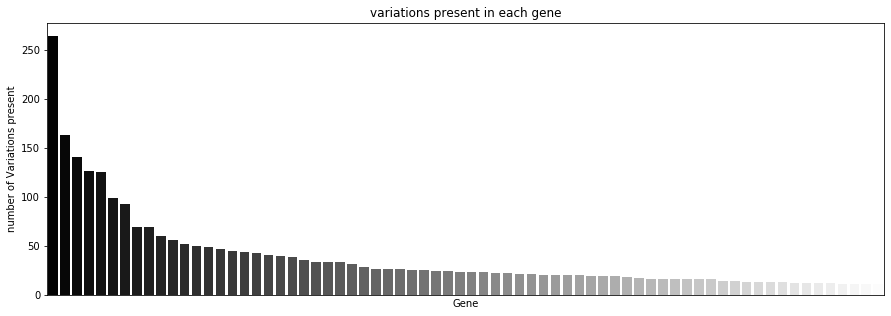


Top 5 Genes are: 
['BRCA1' 'TP53' 'EGFR' 'PTEN' 'BRCA2']


In [740]:
plt.figure(figsize=(15,5))
sns.barplot(x='Gene',y='Variation',data=gene_var[:70],palette='gist_gray',)
plt.xticks([],[])
plt.ylabel("number of Variations present")
plt.title('variations present in each gene')
plt.show()

print("\nTop 5 Genes are: ")
print(gene_var[:5]['Gene'].values)


In [741]:
#MERGING THE TWO DATAFRAMES 
train=pd.merge(left=tr_var,right=tr_text,on='ID',how='inner')

### Text for train data

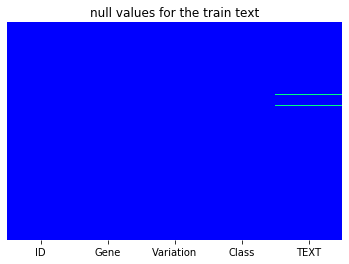

In [742]:
#checking for the null values:
sns.heatmap(train.isnull(),cbar=False,yticklabels=False,cmap='winter')
plt.title("null values for the train text")
plt.show()

In [743]:
#replacing the text with the gene+variation field
train.loc[train['TEXT'].isnull(),'TEXT']=train['Gene']+' '+train['Variation']

In [744]:
dupl_percentage=[]
lab=[]
for C in range(1,10,1):
    cls=train[train['Class']==C]
    dup_cls=train[train['Class']==C].duplicated(subset=['TEXT'],keep='first')
    dupl_percentage.append(np.round((cls[dup_cls].shape[0]*100)/cls.shape[0],2))
    lab.append(C)

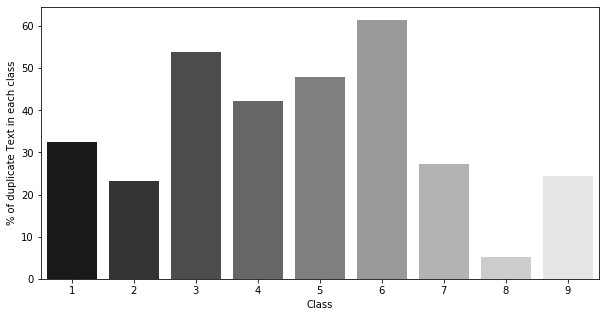

In [745]:
plt.figure(figsize=(10,5))
sns.barplot(x=lab,y=dupl_percentage,palette='gist_gray')
plt.ylabel('% of duplicate Text in each class')
plt.xlabel('Class')
plt.show()

In [746]:
#Collecting text of train and test data so as to preprocess them collectively.
total_text=[]
for tx in train['TEXT'].values:
    total_text.append(tx)

text_df=pd.DataFrame(data=total_text,columns=['TEXT'])
text_df.describe()

TEXT
count                                                3321
unique                                               1925
top     The PTEN (phosphatase and tensin homolog) phos...
freq                                                   53

#### class 6,3,5,4 having more than 40% of their clinical text as duplicate. SO our TEXT ANALYSIS WILL BE ON UNIQUE CLINICAL TEXT ONLY

### To Analyze the words appearing in text

#### Text Preprocessing

In [747]:
#TEXT PREPROCESING...

m_spwrd=set(stopwords.words('english'))
m_spwrd.add('fig')
m_spwrd.add('figure')
m_spwrd.add('table')


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def Text_Preprocess(tx):
    tx=tx.lower()
    #tx=decontracted(tx)
    
    tx=re.sub(r'%',r'percent',tx)
    tx=re.sub(r'-',r"_",tx)
    tx=re.sub(r'\(.*?\)'," ",tx)
    
    #removing the citations
    tx=re.sub(r'\[.*?\]',r" ",tx)
    
    #removing th digits
    tx=re.sub(r'\d{1,5}',r' ',tx)
    
    #removing punctuations..
    tx=re.sub(r'[^A-Za-z]',r' ',tx)
    
    tx=" ".join(wrds.strip() for wrds in tx.split() if wrds not in m_spwrd).strip()
    tx=" ".join(WordNetLemmatizer().lemmatize(wrds) for wrds in tx.split())
    
    #removing the words of length 1 or 2
    tx=re.sub(r'\b\w{1,2}\b',r'',tx)

    return tx.strip()


In [748]:
pr_txts=[]
for tx in tqdm(text_df['TEXT'].values):
    pr_txts.append(Text_Preprocess(tx))

text_df['TEXT']=pr_txts

### OBSERVATIONS ON THE NON DUPLICATED TEXT

### Observations on the unigrams

In [749]:
def Analyze_words(TEXT_clm):
    
    non_dup_text=text_df[~TEXT_clm.duplicated(keep='first')]['TEXT']

    Description=""
    for text in non_dup_text.values:
        for word in text.split(' '):
            Description+=word+" "
    Description=Description.rstrip()

    dict_w=dict(Counter(Description.split()))
    list_w=(sorted(dict_w.items(),key=lambda x:x[1],reverse=True))

    print("TOTAL UNIQUE WORDS IN Whole data ",len(list_w))
    wdf=pd.DataFrame(data=list_w,columns=['Word','Frequency'])
    plt.figure(figsize=(17,15))
    sns.barplot(x='Frequency',y='Word',data=wdf[:60],palette='GnBu_d')
    plt.show()
    return Description


2020-09-02 17:16:03.477972
TOTAL UNIQUE WORDS IN Whole data  69406


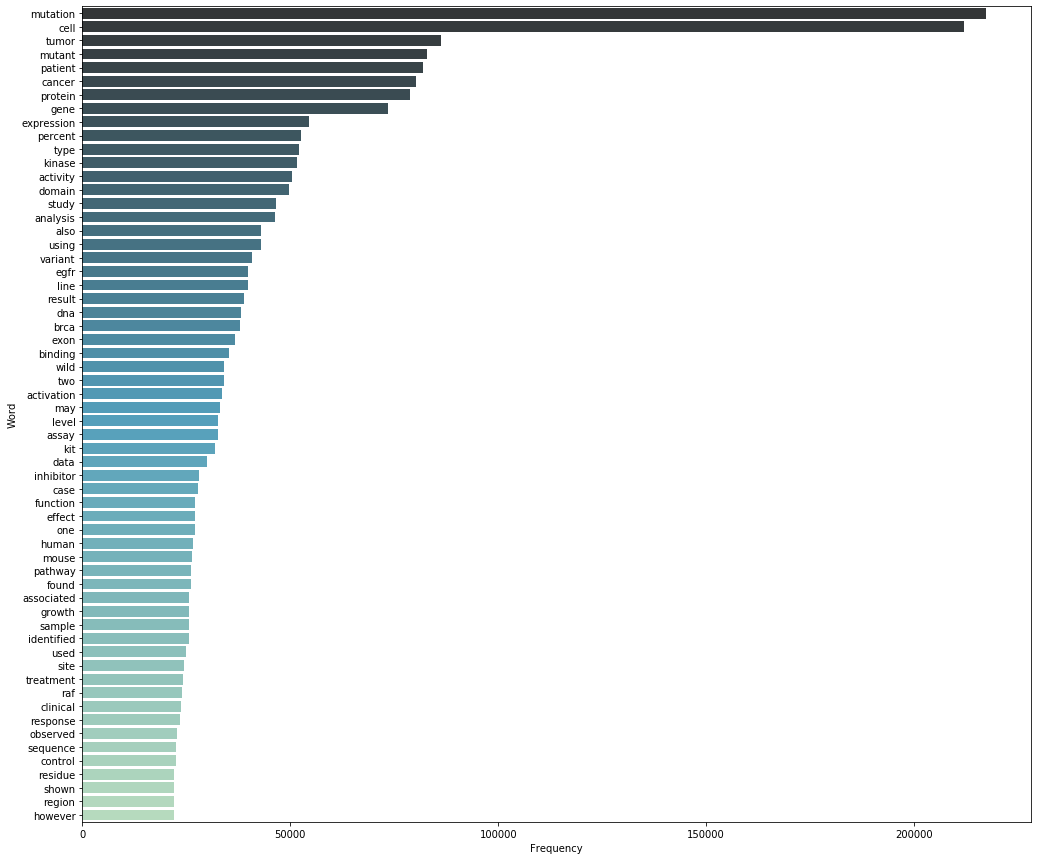

2020-09-02 17:16:35.728225


In [750]:
print(datetime.datetime.now())

Description=Analyze_words(text_df['TEXT'])

print(datetime.datetime.now())

### Removing The Top Frequent Unigrams

In [751]:
#REMOVING THE top 0.5% most frequent UNIGRAMS 

non_dup_text=text_df[~text_df['TEXT'].duplicated(keep='first')]['TEXT']

tf_u=TfidfVectorizer(ngram_range=(1,1),min_df=1)
tf_u.fit(non_dup_text.values)

u_idf=dict(zip(tf_u.get_feature_names(),tf_u.idf_))
l_idf_u=sorted(u_idf.items(),key=lambda x:x[1],reverse=False)

print("Total Unique Unigrams Collected from train data ",len(l_idf_u))

remove_ungm=[]
rem_frac=math.floor(len(l_idf_u)*0.005)
for i in range(rem_frac):
    remove_ungm.append(l_idf_u[i][0])

print("Unigrams that will get removed from the text ",rem_frac)

#removing top common words from the text....

text_df['TEXT']=text_df['TEXT'].apply(lambda x:" ".join(wrds for wrds in x.split() if wrds not in remove_ungm))

Total Unique Unigrams Collected from train data  69406
Unigrams that will get removed from the text  347


TOTAL UNIQUE WORDS IN Whole data  69059


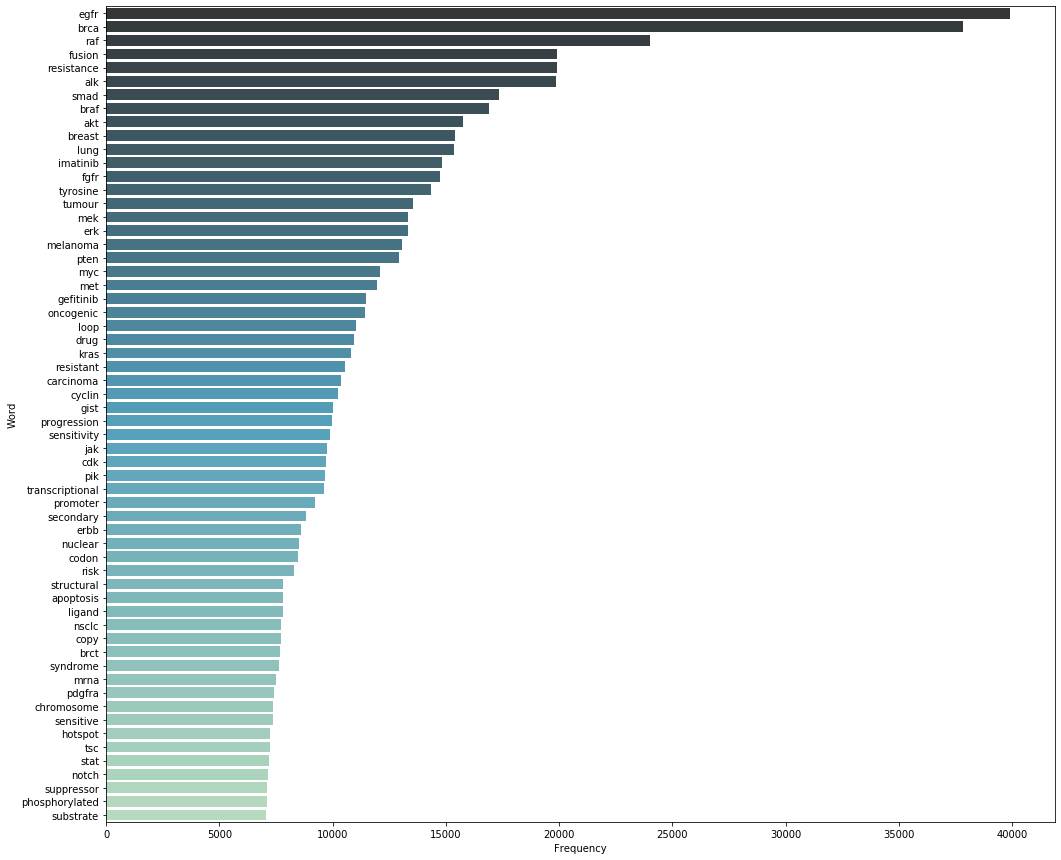

In [752]:
Description=Analyze_words(text_df["TEXT"])

### Biagram analysis

In [182]:
tf_b=TfidfVectorizer(ngram_range=(2,2))
tf_b.fit(non_dup_text.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(2, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [183]:
d_bg=dict(zip(tf_b.get_feature_names(),tf_b.idf_))
list_bgms=sorted(d_bg.items(),key=lambda x:x[1],reverse=False)
print("Total biagrams Collected ",len(list_bgms))

Total biagrams Collected  1891580


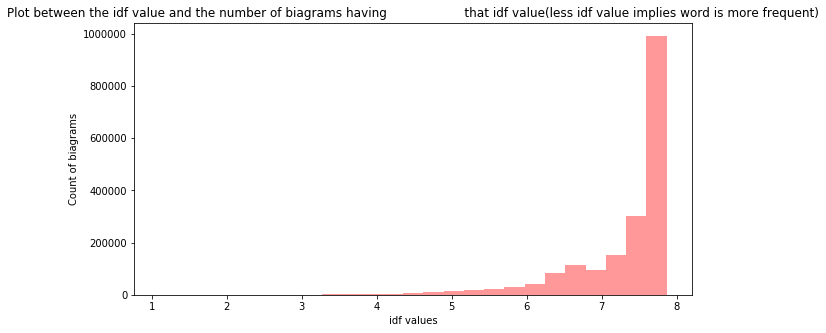

Description of the idf values of biagrams
                 IDF
count   1.891580e+06
mean    7.371542e+00
std     7.401085e-01
min     1.101041e+00
0.001%  1.644477e+00
1%      4.670861e+00
3%      5.384627e+00
5%      5.854631e+00
10%     6.365457e+00
25%     7.176387e+00
50%     7.869534e+00
75%     7.869534e+00
max     7.869534e+00


In [184]:
big_df=pd.DataFrame(list_bgms,columns=['Biagrams','IDF'])
plt.figure(figsize=(10,5))
sns.distplot(a=big_df['IDF'].values,bins=25,kde=False,color='red')
plt.title("Plot between the idf value and the number of biagrams having\
                    that idf value(less idf value implies word is more frequent)")
plt.xlabel('idf values')
plt.ylabel('Count of biagrams')
plt.show()

print("Description of the idf values of biagrams")
print(big_df.describe(percentiles=[0.00001,0.01,0.03,0.05,0.1,0.25,0.50,0.75]))

### this states that biagrams are less frequent (as obvious)  and even lowest 0.01 percent of biagrams (i.e 189 biagrams) has pretty good idf values.It states that biagrams are not that much frequent like unigrams so we can keep them.

### creating a mixed vocabulary out of the unigrams ,biagrams and triagrams

In [754]:
import os

if not os.path.isfile('dict_mxgms.txt'):
    ndT=text_df[~text_df['TEXT'].duplicated(keep='first')]['TEXT']
    min_df=[10,5,2]
    max_feature=[3000,1000,25]
    dict_mxgms={}

    for i in tqdm(range(1,4)):
        tf_maxgms=TfidfVectorizer(ngram_range=(i,i),min_df=min_df[i-1],use_idf=True)
        tf_maxgms.fit(ndT.values)
    
        indices=np.argsort(tf_maxgms.idf_)[:max_feature[i-1]]
        for j in indices:
            dict_mxgms[np.array(tf_maxgms.get_feature_names())[j]]=tf_maxgms.idf_[j]
            
    with open('dict_mxgms.txt','wb') as f:
        pickle.dump(dict_mxgms,f)
    
else:
    with open('dict_mxgms.txt','rb') as f:
        dict_mxgms=pickle.load(f)
    

In [759]:
list_mxgms=sorted(dict_mxgms.items(),key=lambda x:x[1],reverse=False)

#collecting words for vocabulary.....
dict_mxgms=dict(list_mxgms)
mxgm_df=pd.DataFrame(list_mxgms,columns=['Grams','Rareness_Measure'])

vocabulary=list(dict_mxgms.keys())

mxgm_df[1000:1020]

Grams  Rareness_Measure
1000          originally          2.297380
1001       heterogeneity          2.297380
1002       heterogeneous          2.299283
1003        conventional          2.299283
1004             overlap          2.301190
1005           activator          2.301190
1006          side chain          2.305014
1007           underwent          2.306931
1008                 hek          2.308852
1009        successfully          2.310777
1010            prostate          2.310777
1011    room temperature          2.310777
1012            suppress          2.312706
1013           extremely          2.312706
1014               arrow          2.314638
1015                kras          2.314638
1016  mutually exclusive          2.314638
1017            maintain          2.316574
1018               fused          2.318514
1019           subcloned          2.318514

### Vectorizing the whole  training text

In [761]:
tf_idf=TfidfVectorizer(vocabulary=vocabulary)
tf_idf.fit(text_df['TEXT'].values)
vec_tf_train=tf_idf.transform(text_df['TEXT'].values)
print("Shape of complete text after vectorising ",vec_tf_train.shape)

Shape of complete text after vectorising  (3321, 4025)


In [762]:
train_visualize=pd.DataFrame(data=vec_tf_train.toarray(),columns=list(tf_idf.get_feature_names()))
print("Train Data Shape ",train_visualize.shape)

Train Data Shape  (3321, 4025)


In [763]:
train_visualize.head()

yet       key     serum    still  therapeutic  characteristic  \
0  0.005799  0.002812  0.000000  0.00000     0.000000         0.00297   
1  0.020585  0.006655  0.007123  0.00000     0.006982         0.00000   
2  0.020585  0.006655  0.007123  0.00000     0.006982         0.00000   
3  0.000000  0.008306  0.017781  0.00839     0.008714         0.00000   
4  0.006901  0.000000  0.000000  0.00000     0.000000         0.00000   

   structural  detection  targeted  amplified  ...  ice min  request reprint  \
0    0.000000   0.000000  0.002891   0.000000  ...      0.0              0.0   
1    0.000000   0.000000  0.006843   0.007238  ...      0.0              0.0   
2    0.000000   0.000000  0.006843   0.007238  ...      0.0              0.0   
3    0.000000   0.008890  0.008541   0.009034  ...      0.0              0.0   
4    0.032199   0.014327  0.020647   0.000000  ...      0.0              0.0   

   body weight  buffer incubated  nearly half  arg arg  difluoride membrane  \
0          0.0               0.0          0.0      0.0                  0.0   
1          0.0               0.0          0.0      0.0                  0.0   
2          0.0               0.0          0.0      0.0                  0.0   
3          0.0               0.0          0.0      0.0                  0.0   
4          0.0               0.0          0.0      0.0                  0.0   

   brct repeat  colony stimulating  conformation polymorphism  
0          0.0                 0.0                        0.0  
1          0.0                 0.0                        0.0  
2          0.0                 0.0                        0.0  
3          0.0                 0.0                        0.0  
4          0.0                 0.0                        0.0  

[5 rows x 4025 columns]

In [764]:
from sklearn.model_selection import train_test_split

X_tr,X_ts,y_tr,y_ts=train_test_split(train_visualize,outputs,stratify=outputs,test_size=0.2)

In [765]:
from prettytable import PrettyTable
pt=PrettyTable()
pt.field_names=['Train_Data','Cv_Data']
pt.add_row([X_tr.shape,X_ts.shape])
print(pt)

+--------------+-------------+
|  Train_Data  |   Cv_Data   |
+--------------+-------------+
| (2656, 4025) | (665, 4025) |
+--------------+-------------+


In [258]:
### considering text length as a feature

tx_df=pd.DataFrame(train_final_text,columns=['train_Text'])
tx_df.loc[:,'Length']=tx_df['train_Text'].apply(lambda x:len(x.split()))
tx_df['Class']=labels

plt.figure(figsize=(10,6))
sns.violinplot(x='Class',y='Length',data=tx_df,palette='gist_gray')
plt.grid(axis='y')
plt.show()


train_Text  Length  Class
0  cyclin dependent kinase regulate variety funda...    2813      1
1  abstract background non small lung heterogeneo...    2481      2
2  abstract background non small lung heterogeneo...    2481      2
3  recent evidence demonstrated acquired uniparen...    2560      3
4  oncogenic monomeric casitas lineage lymphoma m...    2777      4

## creating the models and getting log_loss

### Logistic regression 

In [766]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,log_loss
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [767]:
def Kfold_cv(clf,x,y,k):
    x=np.array(x)
    skf=StratifiedKFold(n_splits=k)
    avg_tr_ll=0
    avg_ts_ll=0
    for train_indices,test_indices in skf.split(x,y):
       
       
        tr_data=x[train_indices]
        ts_data=x[test_indices]
        
        clf.fit(tr_data,y[train_indices])
        
        tr_pprob=clf.predict_proba(tr_data)
        ts_pprob=clf.predict_proba(ts_data)
    
        
        ll_tr=log_loss(y_true=y[train_indices],y_pred=tr_pprob,labels=clf.classes_)
        ll_ts=log_loss(y_true=y[test_indices],y_pred=ts_pprob,labels=clf.classes_)
        avg_tr_ll+=ll_tr
        avg_ts_ll+=ll_ts
        
    #returning the average of train and test scores......
    return (np.round(avg_tr_ll/3,5),np.round(avg_ts_ll/3,5))

In [768]:
def htune_logr(train_data,train_output,fold):
    param1=[0.0005,10**-3,0.006,10**-2,0.05,10**-1,1,10,100,1000,10000]
    param2=['l1','l2']


    for j in param2:
        tr_ll=[]
        cv_ll=[]
        for i in param1:
            lr=LogisticRegression(C=i,penalty=j,class_weight='balanced',fit_intercept=True)
            a,b=Kfold_cv(lr,train_data,train_output,fold)
            tr_ll.append(a)
            cv_ll.append(b)
        plt.figure(figsize=(9,5))
        plt.grid(axis='y')
        plt.title("for penalty"+str(j))
        sns.lineplot(x=np.log(param1),y=tr_ll,label="train_data")
        #plt.scatter(np.log(param1),tr_auc)
        sns.lineplot(x=np.log(param1),y=cv_ll,label="cv_data")
        sns.scatterplot(x=np.log(param1),y=tr_ll)
        plt.xlabel("log(C)")
        plt.ylabel("log_Loss")
        plt.legend()
        plt.show()


In [769]:
def pltcnf(clf,test_data,test_label):
    predictions=np.argmax(clf.predict_proba(test_data),axis=1)+1
    labels=[x+1 for x in range(9)]
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(y_true=test_label,y_pred=predictions),cmap='Accent',annot=True,fmt='.2f',\
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

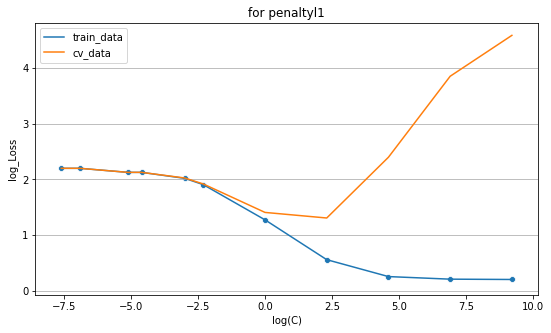

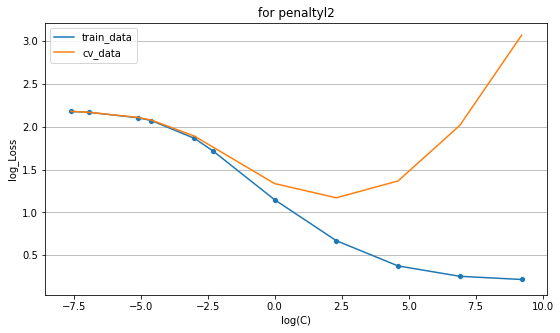

In [770]:
htune_logr(X_tr,y_tr,3)

In [771]:
print("The optimal C is ",param1[7])

The optimal C is  10


In [772]:
lr=LogisticRegression(penalty='l2',C=10,class_weight='balanced',multi_class='ovr',fit_intercept=True,n_jobs=2)
lr.fit(X_tr,y_tr)

print("Train Log Loss is ",log_loss(y_pred=lr.predict_proba(X_tr),y_true=y_tr))
print("Cv Log loss is ",log_loss(y_pred=lr.predict_proba(X_ts),y_true=y_ts))

Train Log Loss is  0.6870183777378169
Cv Log loss is  1.1378054255188739


In [ ]:
pltcnf(lr,X_ts,y_ts)

### Trying the Tfidf-avgw2v to improve the score

#### tfidf-avgw2v with given vocabulary..  each word 300 dimensions.

In [418]:
def Tfidf_avgw2v(values,avgw2vmodel,vocab_avgw2v,dim,dict_word_idf,vocab_for_tfidf,which_data,final_list):
    nr=[]
    glob_vec=np.zeros(dim)
    gl_tfidf=0;
    list1=list(values)
    print("converting to tfidf awgw2v for {}....".format(which_data))
    for text in tqdm(list1):
        vec=np.zeros(dim)
        sum_tfidf=0
        for w in text.split():
            if (w in vocab_avgw2v and w in vocab_for_tfidf):
                vec+=avgw2vmodel[w]
                tf=text.count(w)/len(text.split())
                idf=dict_word_idf[w]
                vec*=tf*idf
                glob_vec+=vec
                sum_tfidf+=tf*idf
                gl_tfidf=sum_tfidf
        
        if(sum_tfidf==0):
            nr.append(list1.index(text))
        else:
            final_list.append(vec/sum_tfidf)
    
    avg_vec=glob_vec/gl_tfidf
    for index in nr:
        final_list.insert(index,avg_vec)

In [421]:
doc_corpus=[]
for txt in non_dup_text.values:
    doc_corpus.append(txt.split())
    
w2v_model=Word2Vec(sentences=doc_corpus,size=300,window=4,min_count=5)
vocab_avgw2v=w2v_model.wv.vocab
    
tf_idf1=TfidfVectorizer(ngram_range=(1,1),min_df=5,use_idf=True,max_features=10000)
tf_idf1.fit(non_dup_text.values)

vocab_for_tfidf=tf_idf1.get_feature_names()
dict_word_idf=dict(zip(tf_idf1.get_feature_names(),tf_idf1.idf_))

In [422]:
if not os.path.isfile('tf_avgwv.txt'):
    train_tfidfw2v=[]
    Tfidf_avgw2v(train2['TEXT'].values,w2v_model,vocab_avgw2v,300,dict_word_idf,vocab_for_tfidf,\
                    'train data',train_tfidfw2v)
    
    with open("tf_avgwv.txt","wb") as f:
    pickle.dump(train_tfidfw2v,f)
    
else:
    with open('tf_avgwv.txt','rb') as f:
        train_tfidfw2v=pickle.load(f)
    


converting to tfidf awgw2v for train data....


[array([ 1.36233918e-04, -2.36601328e-05, -1.21229735e-04, -1.82756195e-04,
        -2.53790841e-06,  3.64972152e-05,  1.33854401e-04,  6.72496972e-05,
         2.06787494e-05, -2.97416592e-06,  5.76388937e-05, -5.45560143e-05,
        -1.94809150e-05,  8.86414192e-06,  5.56933235e-05, -1.94487388e-05,
         4.02822651e-05,  2.27464039e-06,  4.75721555e-05, -5.03253293e-05,
        -6.15254492e-05, -5.39707272e-06,  8.60085826e-05,  8.96339682e-06,
         2.19490128e-06, -6.33191915e-05,  5.67577572e-05, -4.30993537e-06,
        -6.56155123e-05, -5.55154272e-05, -1.71125965e-05,  4.48269884e-05,
        -6.98641040e-05, -1.63231707e-04, -7.65323348e-05,  2.13065534e-05,
         1.82364098e-04, -3.03674949e-05,  5.87270856e-05, -4.85722919e-05,
        -1.55060603e-05,  1.44875270e-06,  4.72223619e-05,  8.70498456e-05,
        -1.13362896e-05,  2.44265134e-05,  4.09280459e-06,  3.74751187e-05,
         1.00220602e-04,  2.19827180e-05, -5.43816616e-06,  1.30460107e-04,
        -3.2

In [436]:
train2=pd.DataFrame(train_tfidfw2v,columns=['dim_'+str(i) for i in range(300)])
train2.head()

gene_freq  variation_freq     dim_0         dim_1     dim_2     dim_3  \
0   0.000301        0.028004  0.000136 -2.366013e-05 -0.000121 -0.000183   
1   0.007528        0.000301 -0.000005 -3.188348e-05 -0.000005 -0.000081   
2   0.007528        0.000301 -0.000005 -3.188348e-05 -0.000005 -0.000081   
3   0.007528        0.000301 -0.000007  2.980713e-07 -0.000009 -0.000014   
4   0.007528        0.000301  0.000029 -1.435056e-04 -0.000065  0.000039   

      dim_4     dim_5     dim_6         dim_7  ...   dim_290   dim_291  \
0 -0.000003  0.000036  0.000134  6.724970e-05  ... -0.000002  0.000132   
1  0.000070  0.000039  0.000020 -7.804492e-07  ... -0.000042 -0.000033   
2  0.000070  0.000039  0.000020 -7.804492e-07  ... -0.000042 -0.000033   
3  0.000025 -0.000005 -0.000009  2.821663e-05  ... -0.000034 -0.000036   
4  0.000200  0.000059 -0.000103  2.664026e-05  ... -0.000003 -0.000192   

    dim_292   dim_293   dim_294   dim_295   dim_296   dim_297   dim_298  \
0 -0.000018 -0.000021 -0.000114 -0.000007  0.000015  0.000047 -0.000028   
1  0.000025 -0.000011  0.000083  0.000046  0.000048 -0.000066  0.000046   
2  0.000025 -0.000011  0.000083  0.000046  0.000048 -0.000066  0.000046   
3  0.000011 -0.000001  0.000031  0.000026  0.000013  0.000006 -0.000002   
4  0.000080 -0.000133  0.000084  0.000168 -0.000059  0.000030 -0.000173   

    dim_299  
0 -0.000035  
1 -0.000016  
2 -0.000016  
3  0.000043  
4  0.000045  

[5 rows x 302 columns]

In [438]:
X_tr1,X_ts1,y_tr1,y_ts1=train_test_split(train2,outputs,stratify=outputs,test_size=0.2)
print("train data shape is ",X_tr1.shape)
print("test data shape is ",X_ts1.shape)

train data shape is  (2656, 302)
test data shape is  (665, 302)


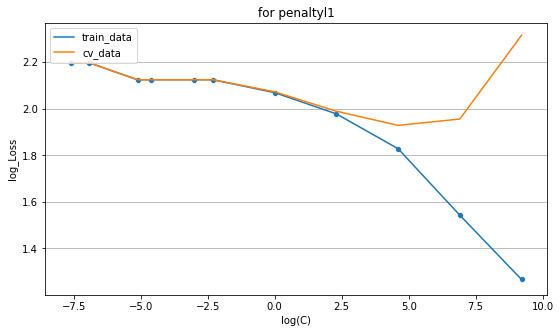

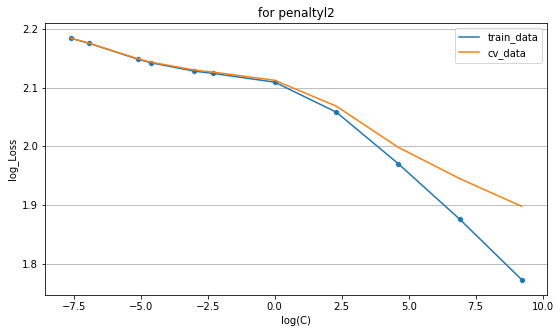

In [446]:
htune_logr(X_tr1,y_tr1,3)

Train Log Loss is  1.7737753307514865
Test Log loss is  1.9516754165177723


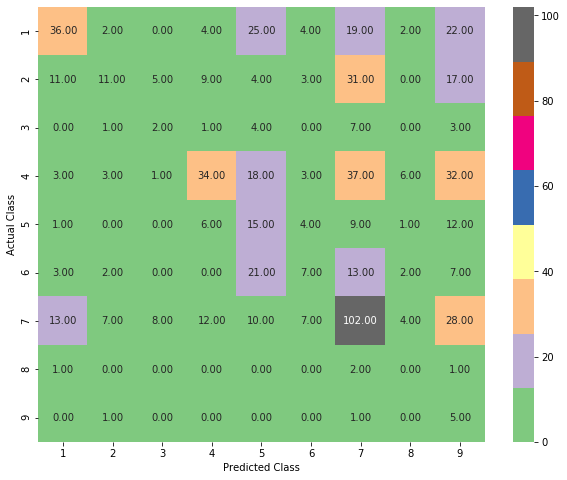

In [451]:
lr1=LogisticRegression(penalty='l2',C=10000,class_weight='balanced',multi_class='ovr',fit_intercept=True,n_jobs=3)
lr1.fit(X_tr1,y_tr1)

print("Train Log Loss is ",log_loss(y_pred=lr1.predict_proba(X_tr1),y_true=y_tr1))
print("Test Log loss is ",log_loss(y_pred=lr1.predict_proba(X_ts1),y_true=y_ts1))

pltcnf(lr1,X_ts1,y_ts1)

### checking for the test data

In [715]:
sub_ts_tx=pd.read_csv("stage2_test_text.csv",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
sub_ts_vr=pd.read_csv('stage2_test_variants.csv')
sub_df=sub_ts_vr.merge(sub_ts_tx,how='left',on='ID')
sub_df.head()

ID    Gene             Variation  \
0   1   CHEK2                 H371Y   
1   2   AXIN2  Truncating Mutations   
2   3    WNT4                 E216G   
3   4  SUCLA2                 G118R   
4   5    BRAF             T599insTT   

                                                TEXT  
0  The incidence of breast cancer is increasing i...  
1  An unselected series of 310 colorectal carcino...  
2  Mycosis fungoides and Sézary syndrome are prim...  
3   Regulated progression through the cell cycle ...  
4  Pilocytic astrocytoma (PA) is emerging as a tu...

In [716]:
sub_txts=[]
for tx in tqdm(sub_ts_tx['TEXT'].values):
    sub_txts.append(Text_Preprocess(tx))

sub_ts_tx['TEXT']=sub_txts

sub_ts_tx['TEXT']=sub_ts_tx['TEXT'].apply(lambda x:" ".join(wrds for wrds in x.split() if wrds not in remove_ungm))

In [717]:
sub_df1=pd.DataFrame(tf_idf.transform(sub_ts_tx['TEXT'].values).toarray(),columns=list(tf_idf.get_feature_names()))

In [718]:
sub_df['Predictions']=lr.predict(sub_df1)
submisson1=pd.concat([sub_df,pd.get_dummies(sub_df['Predictions'])],axis=1)
submisson1=submisson1.drop(columns=['Gene','Variation','TEXT','Predictions'])
submisson1.columns=['ID', 'class1','class2','class3','class4','class5','class6','class7','class8','class9']
submisson1.head()

ID  class1  class2  class3  class4  class5  class6  class7  class8  class9
0   1       0       0       0       0       0       1       0       0       0
1   2       1       0       0       0       0       0       0       0       0
2   3       0       0       0       0       0       0       1       0       0
3   4       0       0       0       0       0       0       1       0       0
4   5       0       0       0       0       0       0       1       0       0

In [719]:
submisson1.to_csv('submisson1.csv',index=False)